In [1]:
import os
if os.name == 'nt':
    %env DOC=C:\Users\BK\Documents
else:
    %env DOC=/Users/muuzh/Documents

from AMI import automutual_info_single, automutual_info, automutual_info_k1

env: DOC=/Users/muuzh/Documents
/Users/muuzh/Documents/JIDT/infodynamics.jar


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
import seaborn as sns
import pandas as pd
import time
import itertools
import scipy.stats as stats
import jpype
import measures as nolds
import datasets as datasets


In [3]:
def poincare_plot(data, stride=1):
    """
    Create a Poincare plot from a time series.

    Parameters
    ----------
    data : array_like
        The time series data.
    stride : int, optional
        The stride between consecutive points in the time series. Default is 1.

    Returns
    -------
    tuple
        A tuple containing the x and y coordinates of the Poincare plot.
    """
    x = data[:-stride]
    y = data[stride:]
    return x, y
def plot_lyap(maptype):
  # local import to avoid dependency for non-debug use
  import matplotlib.pyplot as plt

  x_start = 0.1
  n = 140
  nbifur = 40
  if maptype == "logistic":
    param_name = "r"
    param_range = np.arange(2, 4, 0.01)
    full_data = np.array([
      np.fromiter(datasets.logistic_map(x_start, n, r), dtype="float32")
      for r in param_range
    ])

    lambdas = [
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(full_data, param_range)
    ]
  elif maptype == "tent":
    param_name = "$\\mu$"
    param_range = np.arange(0, 2, 0.01)
    full_data = np.array([
      np.fromiter(datasets.tent_map(x_start, n, mu), dtype="float32")
      for mu in param_range
    ])

    lambdas = np.log(param_range, where=param_range > 0)
    lambdas[np.where(param_range <= 0)] = np.nan
  else:
    # raise Error("maptype %s not recognized" % maptype)
    pass

  kwargs_e = {"emb_dim": 6, "matrix_dim": 2}
  kwargs_r = {"emb_dim": 6, "lag": 2, "min_tsep": 20, "trajectory_len": 20}
  # algorithm of Eckmann
  lambdas_e = [max(nolds.lyap_e(d, **kwargs_e)) for d in full_data]
  # ################
  # 
  # algorithm of Rosenstein
  lambdas_r = [nolds.lyap_r(d, **kwargs_r) for d in full_data]
  # ################
  bifur_x = np.repeat(param_range, nbifur)
  bifur = np.reshape(full_data[:, -nbifur:], nbifur * param_range.shape[0])

  plt.figure(figsize=(10, 6))
  plt.title("Lyapunov exponent of %s map" % maptype)
  plt.plot(param_range, lambdas, "b-", label="theoretical LE")
  elab = "Eckmann method"
  rlab = "largest LE, Rosenstein method"
  plt.plot(param_range, lambdas_e, color="#00AAAA", label=elab)
  plt.plot(param_range, lambdas_r, color="#AA00AA", label=rlab)
  plt.plot(param_range, np.zeros(len(param_range)), "g--")
  plt.plot(bifur_x, bifur, "ro", alpha=0.1, label="bifurcation plot")
  plt.ylim((-2, 2))
  plt.xlabel(param_name)
  plt.ylabel("LE")
  plt.legend(loc="best")
  plt.show()

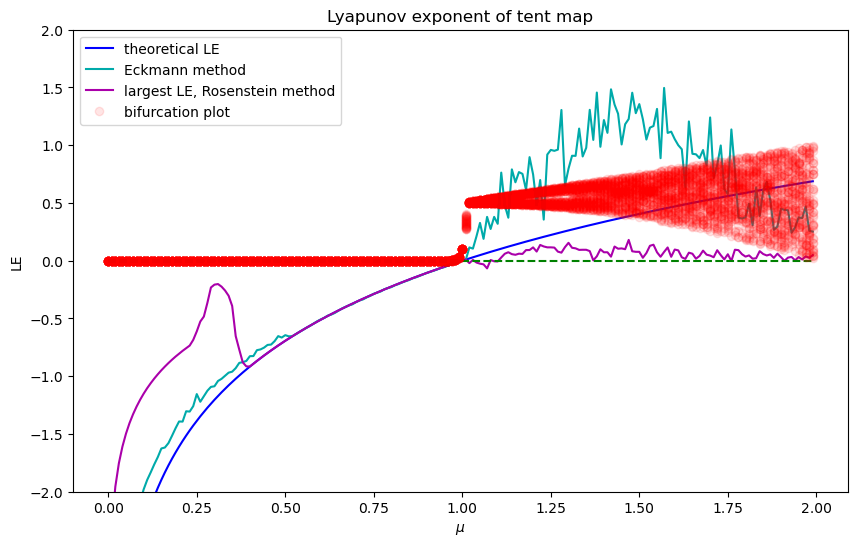

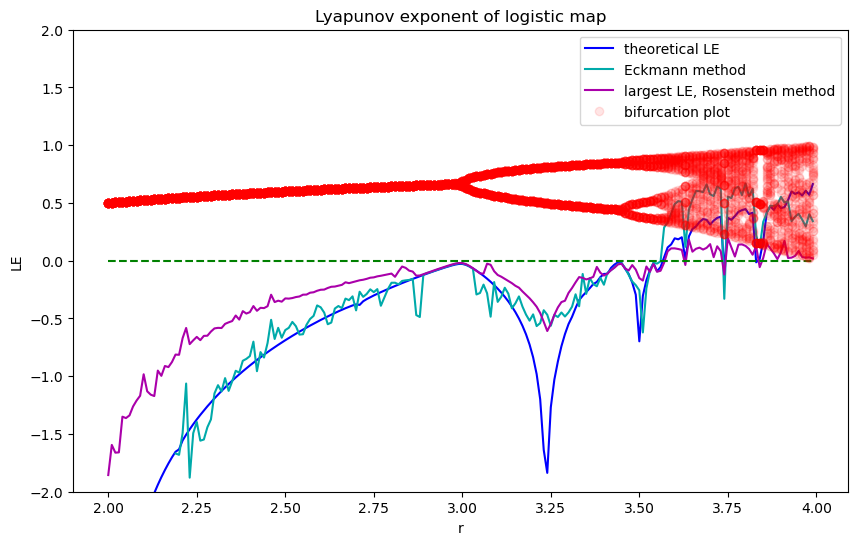

In [4]:
plot_lyap("tent")
plot_lyap("logistic")

In [5]:
x_start = 0.1
series_length = 2200
logistic_num = tent_a_num = 500

param_range_tent = np.linspace(1.001, 1.999, tent_a_num)
param_range_logistic = np.linspace(3.57, 4, logistic_num)

tent_full_data = np.array([
    np.fromiter(datasets.tent_map(x_start, series_length, mu), dtype="float32")
    for mu in param_range_tent
])
logistic_full_data = np.array([
    np.fromiter(datasets.logistic_map(x_start, series_length, r), dtype="float32")
    for r in param_range_logistic
])


# delete the first 200 points for each series
tent_full_data = tent_full_data[:, 200:]
logistic_full_data = logistic_full_data[:, 200:]

In [6]:
# Define AMI_distance to be: For a random point in AC1 AMI1 space, compute AMI values for AR(1) series with parameter that equal to this AC1, 
# then number of stds away from the mean of AR(1) series is defined to be the distance
def AMI_for_AR1(AC1, sample_size=100):
    # genenerate AR(1) series with AC1, with sample_size points
    lag1para = AC1
    series_length = 2000
    ARpara = np.r_[1, -lag1para]
    AR1matrix = np.array([ArmaProcess(ARpara, [1]).generate_sample(series_length) for _ in trange(sample_size)])
    AR1AMI1 = automutual_info(AR1matrix, 1, 3)
    return AR1AMI1
def AMI_for_AR1_all_at_once(AC1s, sample_size=100, series_length=2000):
    # genenerate AR(1) series with AC1, with sample_size points
    lag1para = AC1s
    ARpara = [np.r_[1, -arparams] for arparams in AC1s]
    AR1matrix = np.full((len(AC1s), sample_size, series_length), np.nan)
    for i, ar in enumerate(ARpara):
        AR1matrix[i] = [ArmaProcess(ar, [1]).generate_sample(series_length) for _ in range(sample_size)]
    AR1AMI1 = automutual_info(AR1matrix, 1, 3)
    return AR1AMI1

In [7]:
logisticAMI1 = automutual_info(logistic_full_data, 1, 3)

Processing:   0%|          | 0/500 [00:00<?, ?it/s]

In [8]:
logisticAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in logistic_full_data
])
logisticAC1 = np.abs(logisticAC1)

logisticAMI1_AR1 = AMI_for_AR1_all_at_once(logisticAC1, sample_size=100)


Processing:   0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
logistic_AMI_distance = (np.array(logisticAMI1) - np.array((logisticAMI1_AR1.mean(axis=1))))/np.array((logisticAMI1_AR1.std(axis=1)))

In [15]:
tentLambdas = np.log(param_range_tent, where=param_range_tent > 0)
logisticLambdas =np.array([
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(logistic_full_data, param_range_logistic)
    ])

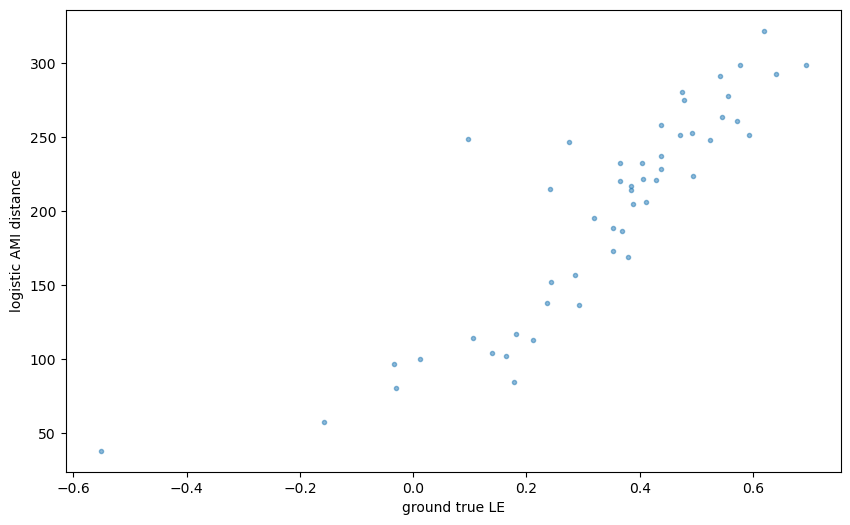

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(logisticLambdas, logistic_AMI_distance, marker='.',alpha=0.5)
plt.xlabel("ground true LE")
plt.ylabel("logistic AMI distance")
plt.show()

In [23]:
length = [300, 600, 900, 1200, 1500, 1900]
logistic_length_result = []
for l in length:
    x_start = 0.1
    series_length = l + 200
    logistic_num = tent_a_num = 50

    param_range_tent = np.linspace(1.001, 1.999, tent_a_num)
    param_range_logistic = np.linspace(3.57, 4, logistic_num)

    tent_full_data = np.array([
        np.fromiter(datasets.tent_map(x_start, series_length, mu), dtype="float32")
        for mu in param_range_tent
    ])
    logistic_full_data = np.array([
        np.fromiter(datasets.logistic_map(x_start, series_length, r), dtype="float32")
        for r in param_range_logistic
    ])


    # delete the first 200 points for each series
    tent_full_data = tent_full_data[:, 200:]
    logistic_full_data = logistic_full_data[:, 200:]
    logisticAMI1 = automutual_info(logistic_full_data, 1, 3)
    logisticAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in logistic_full_data
    ])
    logisticAC1 = np.abs(logisticAC1)

    logisticAMI1_AR1 = AMI_for_AR1_all_at_once(logisticAC1, sample_size=100, series_length=l)
    logistic_AMI_distance = (np.array(logisticAMI1) - np.array((logisticAMI1_AR1.mean(axis=1))))/np.array((logisticAMI1_AR1.std(axis=1)))
    logistic_length_result.append(logistic_AMI_distance)


Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

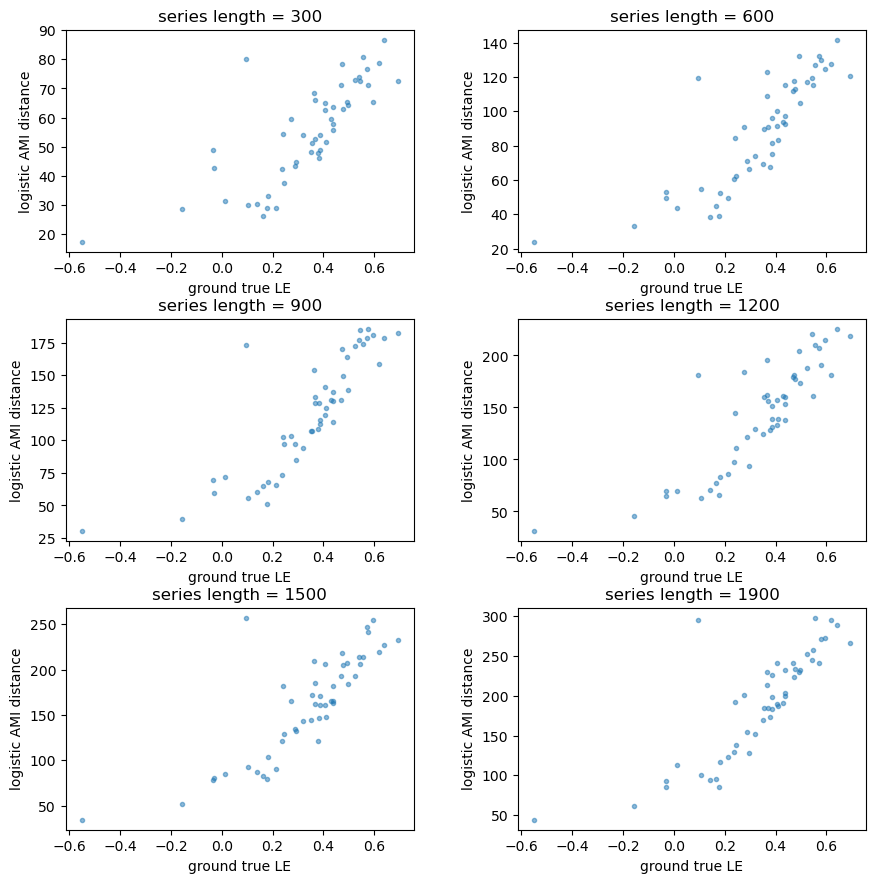

In [25]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
for i, l in enumerate(length):
    plt.subplot(3, 2, i+1)
    plt.scatter(logisticLambdas, logistic_length_result[i], marker='.',alpha=0.5)
    plt.xlabel("ground true LE")
    plt.ylabel("logistic AMI distance")
    plt.title("series length = {}".format(l))
plt.show()

In [26]:
# compute the correlation between LE and AMI distance for each
# logistic map series
logistic_correlation = np.array([
    np.corrcoef(logisticLambdas, logistic_length_result[i])[0, 1]
    for i in range(len(length))
    ])



In [27]:
logistic_correlation

array([0.77594527, 0.82873246, 0.83690097, 0.84903447, 0.81931165,
       0.83233251])

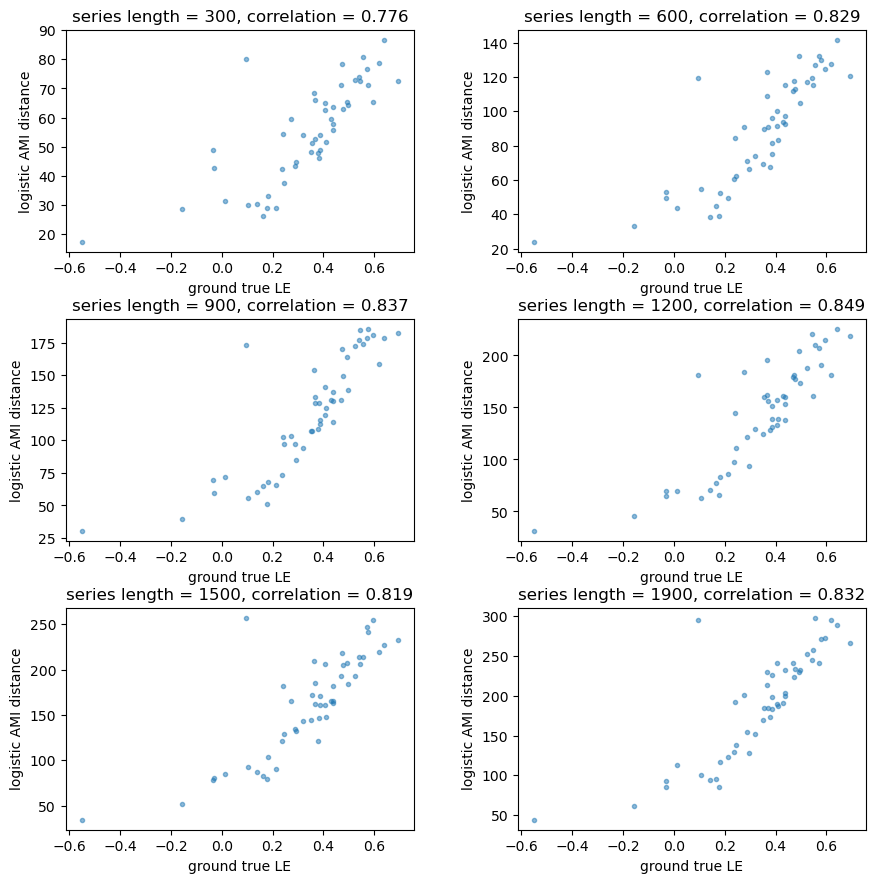

In [28]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
for i, l in enumerate(length):
    plt.subplot(3, 2, i+1)
    plt.scatter(logisticLambdas, logistic_length_result[i], marker='.',alpha=0.5)
    plt.xlabel("ground true LE")
    plt.ylabel("logistic AMI distance")
    plt.title("series length = {}, correlation = {:.3f}".format(l, logistic_correlation[i]))
plt.show()

In [29]:
lambda_e_length_result = []
for l in length:
    x_start = 0.1
    series_length = l + 200
    logistic_num = tent_a_num = 50

    param_range_tent = np.linspace(1.001, 1.999, tent_a_num)
    param_range_logistic = np.linspace(3.57, 4, logistic_num)

    # tent_full_data = np.array([
    #     np.fromiter(datasets.tent_map(x_start, series_length, mu), dtype="float32")
    #     for mu in param_range_tent
    # ])
    logistic_full_data = np.array([
        np.fromiter(datasets.logistic_map(x_start, series_length, r), dtype="float32")
        for r in param_range_logistic
    ])
    kwargs_e = {"emb_dim": 6, "matrix_dim": 2}
    lambdas_e = [max(nolds.lyap_e(d, **kwargs_e)) for d in tqdm(logistic_full_data)]
    lambda_e_length_result.append(lambdas_e)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [32]:
lambda_e_correlation = np.array([
    np.corrcoef(logisticLambdas, lambda_e_length_result[i])[0, 1]
    for i in range(len(length))
    ])

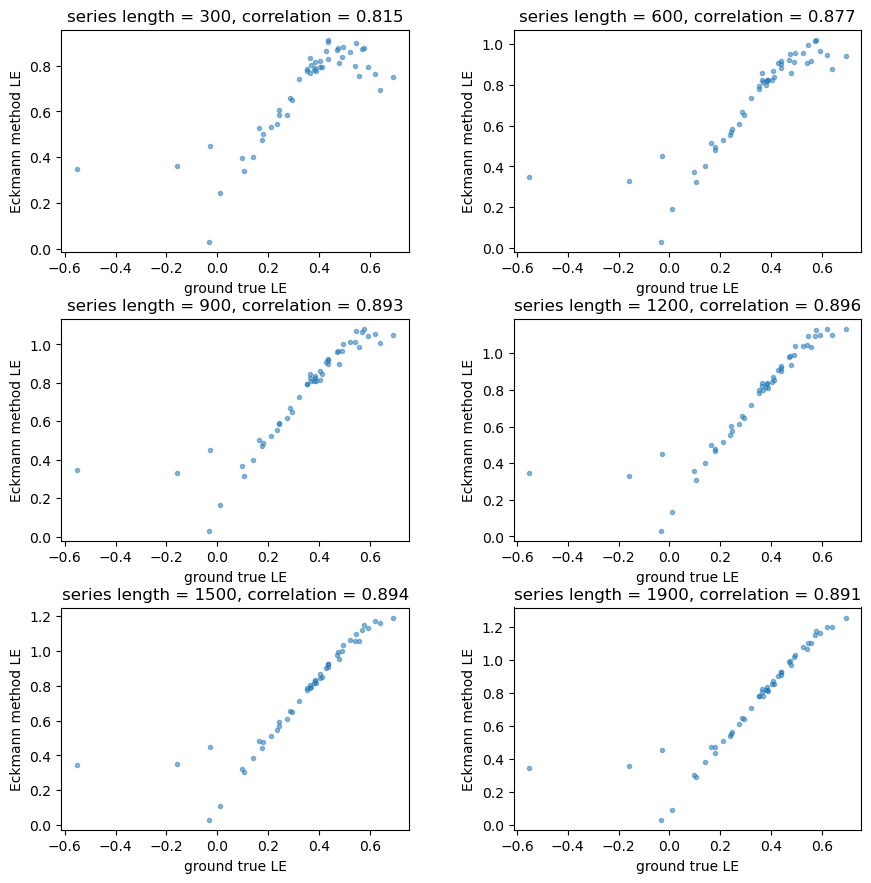

In [34]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
for i, l in enumerate(length):
    plt.subplot(3, 2, i+1)
    plt.scatter(logisticLambdas, lambda_e_length_result[i], marker='.',alpha=0.5)
    plt.xlabel("ground true LE")
    plt.ylabel("Eckmann method LE")
    plt.title("series length = {}, correlation = {:.3f}".format(l, lambda_e_correlation[i]))
plt.show()

In [36]:
noise_level = [0.1, 0.3, 0.5, 0.7, 0.9]
logistic_noise_result = []
x_start = 0.1
l = 1000
series_length = l + 200
logistic_num = tent_a_num = 50

param_range_tent = np.linspace(1.001, 1.999, tent_a_num)
param_range_logistic = np.linspace(3.57, 4, logistic_num)

tent_full_data = np.array([
    np.fromiter(datasets.tent_map(x_start, series_length, mu), dtype="float32")
    for mu in param_range_tent
])
logistic_full_data = np.array([
    np.fromiter(datasets.logistic_map(x_start, series_length, r), dtype="float32")
    for r in param_range_logistic
])
tent_full_data = tent_full_data[:, 200:]
logistic_full_data = logistic_full_data[:, 200:]
for noise in noise_level:
    # delete the first 200 points for each series
    # add measurement noise, noise level is ratio of power of each series
    for i in range(logistic_num):
        logistic_full_data[i] += noise*np.mean(logistic_full_data[i])*np.random.randn(l)
    logisticAMI1 = automutual_info(logistic_full_data, 1, 3)
    logisticAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in logistic_full_data
    ])
    logisticAC1 = np.abs(logisticAC1)

    logisticAMI1_AR1 = AMI_for_AR1_all_at_once(logisticAC1, sample_size=100, series_length=l)
    logistic_AMI_distance = (np.array(logisticAMI1) - np.array((logisticAMI1_AR1.mean(axis=1))))/np.array((logisticAMI1_AR1.std(axis=1)))
    logistic_noise_result.append(logistic_AMI_distance)

Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing:   0%|          | 0/50 [00:00<?, ?it/s]

Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

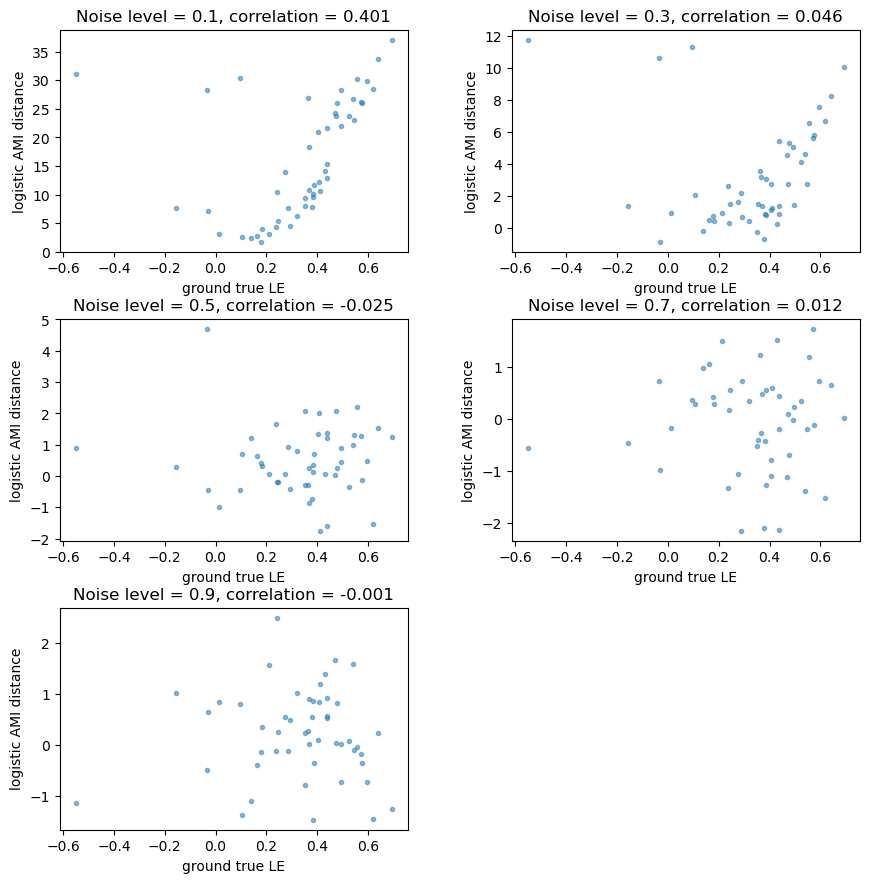

In [37]:
logistic_noise_correlation = np.array([
    np.corrcoef(logisticLambdas, logistic_noise_result[i])[0, 1]
    for i in range(len(noise_level))
    ])

plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
for i, l in enumerate(noise_level):
    plt.subplot(3, 2, i+1)
    plt.scatter(logisticLambdas, logistic_noise_result[i], marker='.',alpha=0.5)
    plt.xlabel("ground true LE")
    plt.ylabel("logistic AMI distance")
    plt.title("Noise level = {}, correlation = {:.3f}".format(l, logistic_noise_correlation[i]))
plt.show()

In [38]:
e_noise_result = []
x_start = 0.1
l = 1000
series_length = l + 200
logistic_num = tent_a_num = 50

param_range_tent = np.linspace(1.001, 1.999, tent_a_num)
param_range_logistic = np.linspace(3.57, 4, logistic_num)

tent_full_data = np.array([
    np.fromiter(datasets.tent_map(x_start, series_length, mu), dtype="float32")
    for mu in param_range_tent
])
logistic_full_data = np.array([
    np.fromiter(datasets.logistic_map(x_start, series_length, r), dtype="float32")
    for r in param_range_logistic
])
tent_full_data = tent_full_data[:, 200:]
logistic_full_data = logistic_full_data[:, 200:]
for noise in noise_level:
    # delete the first 200 points for each series
    # add measurement noise, noise level is ratio of power of each series
    for i in range(logistic_num):
        logistic_full_data[i] += noise*np.mean(logistic_full_data[i])*np.random.randn(l)
    kwargs_e = {"emb_dim": 6, "matrix_dim": 2}
    lambdas_e = [max(nolds.lyap_e(d, **kwargs_e)) for d in tqdm(logistic_full_data)]
    e_noise_result.append(lambdas_e)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

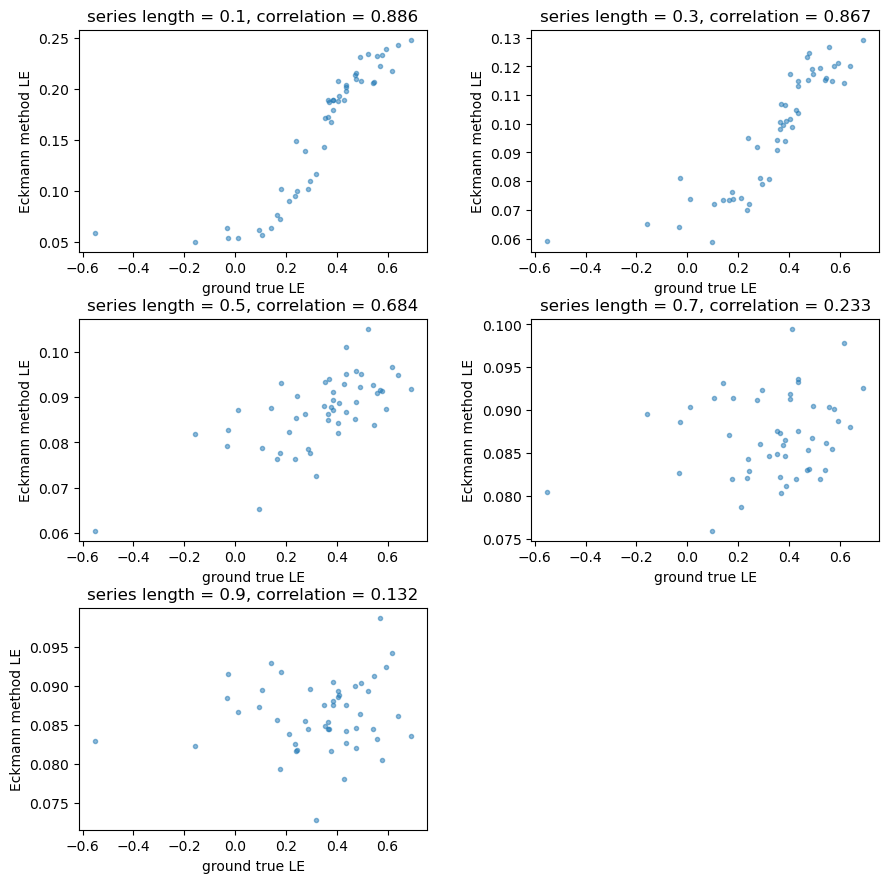

In [40]:
lambda_e_noise_correlation = np.array([
    np.corrcoef(logisticLambdas, e_noise_result[i])[0, 1]
    for i in range(len(noise_level))
    ])
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
for i, l in enumerate(noise_level):
    plt.subplot(3, 2, i+1)
    plt.scatter(logisticLambdas, e_noise_result[i], marker='.',alpha=0.5)
    plt.xlabel("ground true LE")
    plt.ylabel("Eckmann method LE")
    plt.title("series length = {}, correlation = {:.3f}".format(l, lambda_e_noise_correlation[i]))
plt.show()